In [1]:
Create_Dataset_folders = 0
Retrain_Model = 1
first_run = 1

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
from distutils.filelist import FileList
import pprint

In [4]:
import tensorflow as tf
from tensorflow.keras import layers

In [5]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [6]:
import os
import shutil
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [7]:
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/5th_Year_Project/sixth_Iteration_CNN_Live/'

In [8]:
dataset =BASE_PATH + 'v3Dataset/'
print(dataset)

/content/drive/MyDrive/Colab Notebooks/5th_Year_Project/sixth_Iteration_CNN_Live/v3Dataset/


In [9]:

batch_size = 32
num_classes = 6

In [10]:
import numpy as np

def create_population(n, num_weights):
    """
    Creates a population of n individuals, each with num_weights random weights.
    """
    population = []
    for i in range(n):
        individual = np.random.randn(num_weights)
        population.append(individual)
    return population

def compute_fitness(model, population, train_dataset, valid_dataset):
    """
    Computes the fitness of each individual in the population using the validation accuracy
    of the model on the given datasets.
    """
    fitness_values = []
    for individual in population:
        model.set_weights(individual)
        _, accuracy = model.evaluate(valid_dataset)
        fitness_values.append(accuracy)
    return fitness_values

def select_parents(population, fitness_values):
    """
    Selects two parents from the population using fitness-proportional selection.
    """
    total_fitness = sum(fitness_values)
    probabilities = [fitness / total_fitness for fitness in fitness_values]
    parent1_index = np.random.choice(len(population), p=probabilities)
    parent2_index = np.random.choice(len(population), p=probabilities)
    return population[parent1_index], population[parent2_index]

def crossover(parent1, parent2):
    """
    Performs a simple crossover operation between two parents.
    """
    child = np.zeros_like(parent1)
    for i in range(len(parent1)):
        if np.random.rand() < 0.5:
            child[i] = parent1[i]
        else:
            child[i] = parent2[i]
    return child

def mutate(individual, mutation_rate):
    """
    Performs random mutations on an individual.
    """
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:
            individual[i] += np.random.randn() * 0.1
    return individual

def genetic_algorithm(model, train_dataset, valid_dataset, population_size=20, num_generations=10,
                      mutation_rate=0.1):
    """
    Runs a genetic algorithm to optimize the weights of the model on the given datasets.
    """
    num_weights = len(model.get_weights())
    population = create_population(population_size, num_weights)
    for i in range(num_generations):
        fitness_values = compute_fitness(model, population, train_dataset, valid_dataset)
        new_population = []
        for j in range(population_size):
            parent1, parent2 = select_parents(population, fitness_values)
            child = crossover(parent1, parent2)
            child = mutate(child, mutation_rate)
            new_population.append(child)
        population = new_population
    return population[0]


/content/drive/MyDrive/Colab Notebooks/5th_Year_Project/sixth_Iteration_CNN_Live/v3Dataset/
Training on dataset 1/17...
/content/drive/MyDrive/Colab Notebooks/5th_Year_Project/sixth_Iteration_CNN_Live/v3Dataset/Dataset1/train
/content/drive/MyDrive/Colab Notebooks/5th_Year_Project/sixth_Iteration_CNN_Live/v3Dataset/Dataset1/test
/content/drive/MyDrive/Colab Notebooks/5th_Year_Project/sixth_Iteration_CNN_Live/v3Dataset/Dataset1/valid
Found 6975 images belonging to 6 classes.
Found 1994 images belonging to 6 classes.
Found 999 images belonging to 6 classes.
Epoch 1/20
33/33 [==============================] - 939s 28s/step - loss: 1.6624 - acc: 0.2626 - val_loss: 1.5559 - val_acc: 0.2604
Epoch 2/20
33/33 [==============================] - 569s 17s/step - loss: 1.6139 - acc: 0.2773 - val_loss: 1.5459 - val_acc: 0.2719
Epoch 3/20
33/33 [==============================] - 384s 12s/step - loss: 1.5698 - acc: 0.2677 - val_loss: 1.5518 - val_acc: 0.2875
Epoch 4/20
33/33 [========================

Text(0.5, 1.0, 'Training and validation accuracy')

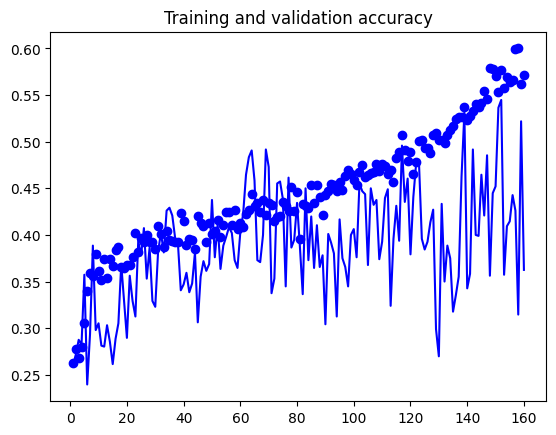

In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

data_folder = dataset
datasets = []

# Set mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)


print(data_folder)
for folder_name in os.listdir(data_folder):
    folder_path = os.path.join(data_folder, folder_name)
    if os.path.isdir(folder_path):
        datasets.append(folder_path)


# Set batch size and number of epochs
batch_size = 60

epochs = 20

# Define the CNN model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, (3, 2), activation="relu", input_shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(16, (3, 2), activation="relu"),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.3, seed=2023),
    tf.keras.layers.Dense(250, activation="relu"),
    tf.keras.layers.Dropout(0.2, seed=2023),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dropout(0.2, seed=2023),
    tf.keras.layers.Dense(6, activation="softmax")
])

model.build()

# Compile the model
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["acc"])

# Train the model on multiple datasets
histories = []
for i, dataset in enumerate(datasets):
  if i<8:
      print(f"Training on dataset {i+1}/{len(datasets)}...")
      
      # Get the train, test, and validation directories for this dataset
      train_dir = os.path.join(dataset, 'train')
      print(train_dir)
      test_dir = os.path.join(dataset, 'test')
      print(test_dir)
      valid_dir = os.path.join(dataset, 'valid')
      print(valid_dir)

      train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
          rescale=1./255,
          rotation_range=20,
          width_shift_range=0.2,
          height_shift_range=0.2,
          shear_range=0.2,
          zoom_range=0.2,
          horizontal_flip=True,
          fill_mode='nearest'
      )
      train_dataset = train_generator.flow_from_directory(
          train_dir,
          target_size=(150, 150),
          batch_size=batch_size,
          class_mode='categorical'
      )

      valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(
          rescale=1./255
      )
      valid_dataset = valid_generator.flow_from_directory(
          valid_dir,
          target_size=(150, 150),
          batch_size=batch_size,
          class_mode='categorical'
      )
      test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
          rescale=1./255
      )
      test_dataset = test_generator.flow_from_directory(
          test_dir,
          target_size=(150, 150),
          batch_size=batch_size,
          class_mode='categorical'
      )


      train_steps = 2000 // batch_size
      val_steps = 1000 // batch_size
      test_steps = 500 // batch_size

      # Compile the model
      model.compile(optimizer='rmsprop',
                    loss='categorical_crossentropy',
                    metrics=['acc'])
      
      # # Apply genetic algorithm between each dataset
      # if i > 0:
      #     weights = genetic_algorithm(model, previous_valid_dataset, valid_dataset)
      #     model.set_weights(weights)

      # Train the model
      history = model.fit(train_dataset,
                          epochs=epochs,
                          steps_per_epoch=train_steps,
                          validation_data=valid_dataset,
                          validation_steps=val_steps)
      
      histories.append(history.history)

# Concatenate the histories
acc = np.concatenate([history["acc"] for history in histories])
val_acc = np.concatenate([history["val_acc"] for history in histories])
loss = np.concatenate([history["loss"] for history in histories])
val_loss = np.concatenate([history["val_loss"] for history in histories])
epochs = range(1, len(acc) + 1)

# Plot the evaluation results
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")


In [12]:
if Retrain_Model: 
  model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 149, 8)       152       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 148, 16)      784       
                                                                 
 conv2d_2 (Conv2D)           (None, 144, 146, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 72, 73, 32)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 70, 71, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 64)       0         
 2D)                                                    

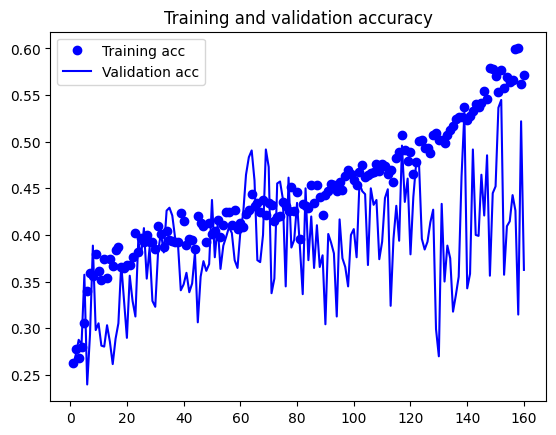

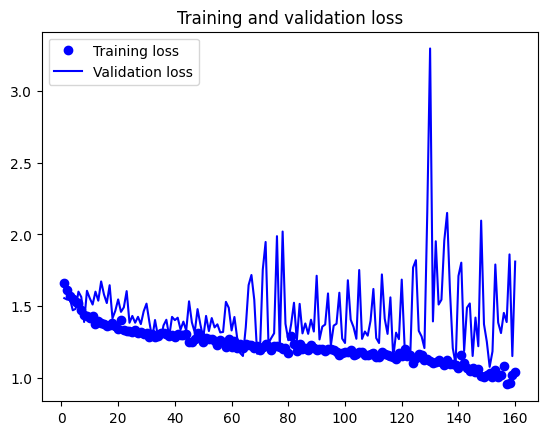

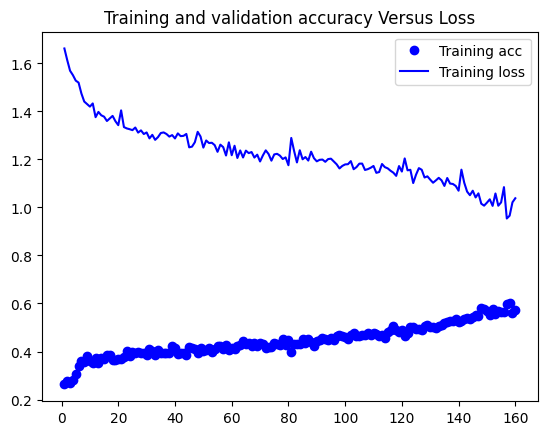

In [13]:
if Retrain_Model:   
  # Plot the evaluation results

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.title('Training and validation accuracy Versus Loss')
  plt.legend()
  plt.show()

34/34 [==============================] - 4s 127ms/step


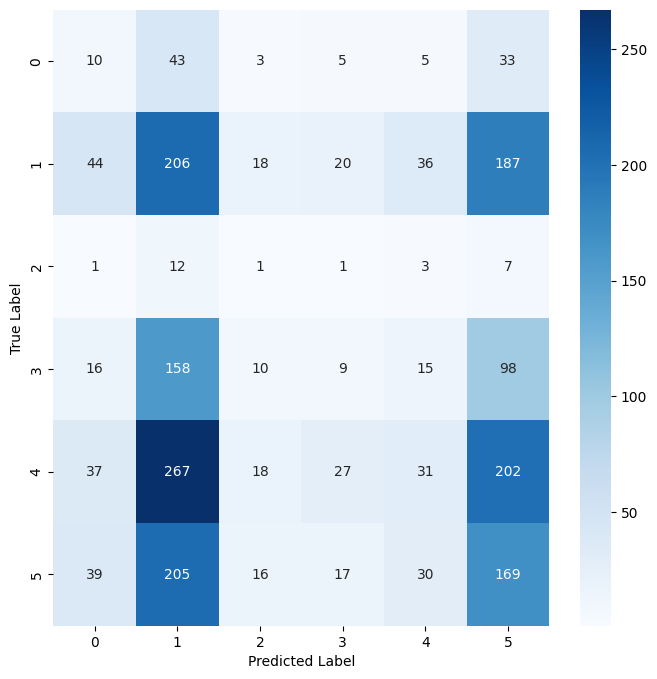

In [15]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the validation set
y_pred = model.predict(valid_dataset)

# Convert the predictions from one-hot encoded to class labels
y_pred = np.argmax(y_pred, axis=1)

# Get the true class labels
y_true = valid_dataset.classes

# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [16]:
keras_model_path = BASE_PATH + "keras_saved_model"
model.save(keras_model_path)

In [17]:
restored_keras_model = tf.keras.models.load_model(keras_model_path)

In [18]:
# Load the trained model
model = restored_keras_model

# Evaluate the model
eval_loss, eval_acc = model.evaluate(valid_dataset)
print("Evaluation loss: ", eval_loss)
print("Evaluation accuracy: ", eval_acc)

34/34 [==============================] - 4s 109ms/step - loss: 1.8608 - acc: 0.3647
Evaluation loss:  1.8607643842697144
Evaluation accuracy:  0.3646823465824127


1/1 [==============================] - 0s 23ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.03      0.05      0.04        99
           1       0.37      0.65      0.48       511
           2       0.11      0.28      0.15        25
           3       0.96      0.25      0.39       306
           4       0.46      0.09      0.16       582
           5       0.36      0.53      0.43       476

    accuracy                           0.36      1999
   macro avg       0.38      0.31      0.28      1999
weighted avg       0.47      0.36      0.33      1999

Confusion Matrix
[[  5  24   0   0   1  69]
 [  1 333  15   1  16 145]
 [  0  12   7   0   0   6]
 [140  34   1  76  18  37]
 [  1 314  26   0  55 186]
 [  0 174  17   2  30 253]]


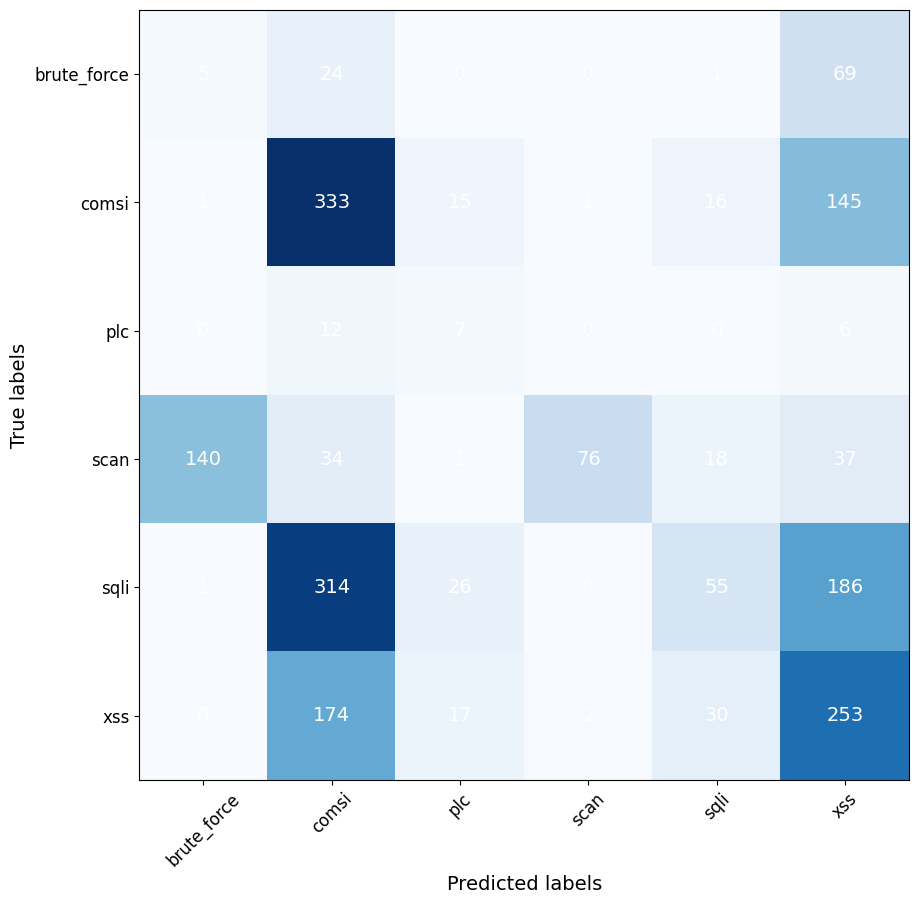

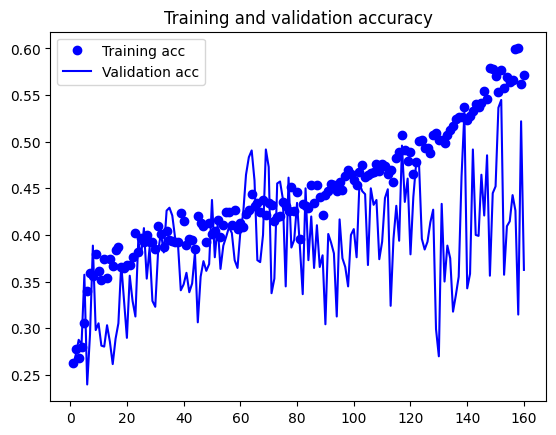

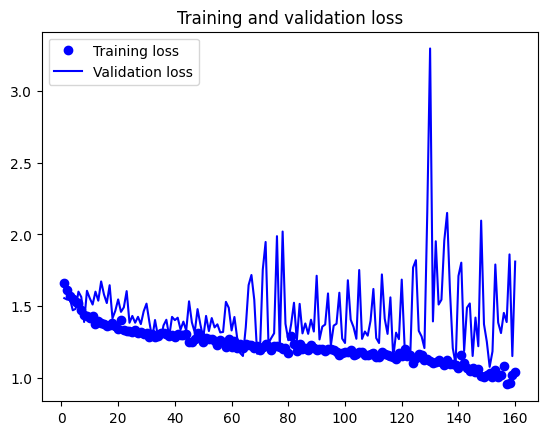

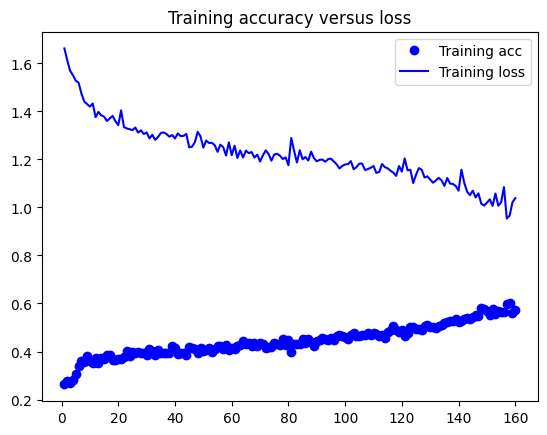

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Get the true labels and predicted labels on the validation set
Y_val = []
Y_pred = []
for i in range(len(valid_dataset)):
    x_val, y_val = valid_dataset[i]
    Y_val.extend(np.argmax(y_val, axis=1))
    Y_pred.extend(np.argmax(model.predict(x_val), axis=1))

# Generate a classification report and confusion matrix
print('Classification Report')
print(classification_report(Y_val, Y_pred))
print('Confusion Matrix')
cm = confusion_matrix(Y_val, Y_pred)
print(cm)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cm, cmap='Blues')
ax.grid(False)
ax.set_xlabel('Predicted labels', fontsize=14, color='black')
ax.set_ylabel('True labels', fontsize=14, color='black')
ax.set_xticks(range(len(valid_dataset.class_indices)))
ax.set_xticklabels(valid_dataset.class_indices.keys(), fontsize=12, rotation=45)
ax.set_yticks(range(len(valid_dataset.class_indices)))
ax.set_yticklabels(valid_dataset.class_indices.keys(), fontsize=12)
for i in range(len(valid_dataset.class_indices)):
    for j in range(len(valid_dataset.class_indices)):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white', fontsize=14)
plt.show()


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training accuracy versus loss')
plt.legend()
plt.show()

2/2 [==============================] - 0s 115ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.03      0.04      0.03        45
           1       0.37      0.63      0.47       262
           2       0.10      0.57      0.17         7
           3       0.95      0.23      0.37       155
           4       0.40      0.07      0.13       295
           5       0.34      0.50      0.40       234

    accuracy                           0.35       998
   macro avg       0.36      0.34      0.26       998
weighted avg       0.44      0.35      0.32       998

Confusion Matrix
[[  2  13   1   0   0  29]
 [  0 164  12   0  10  76]
 [  1   2   4   0   0   0]
 [ 76  17   0  36  11  15]
 [  0 149  11   2  22 111]
 [  0  93  12   0  12 117]]


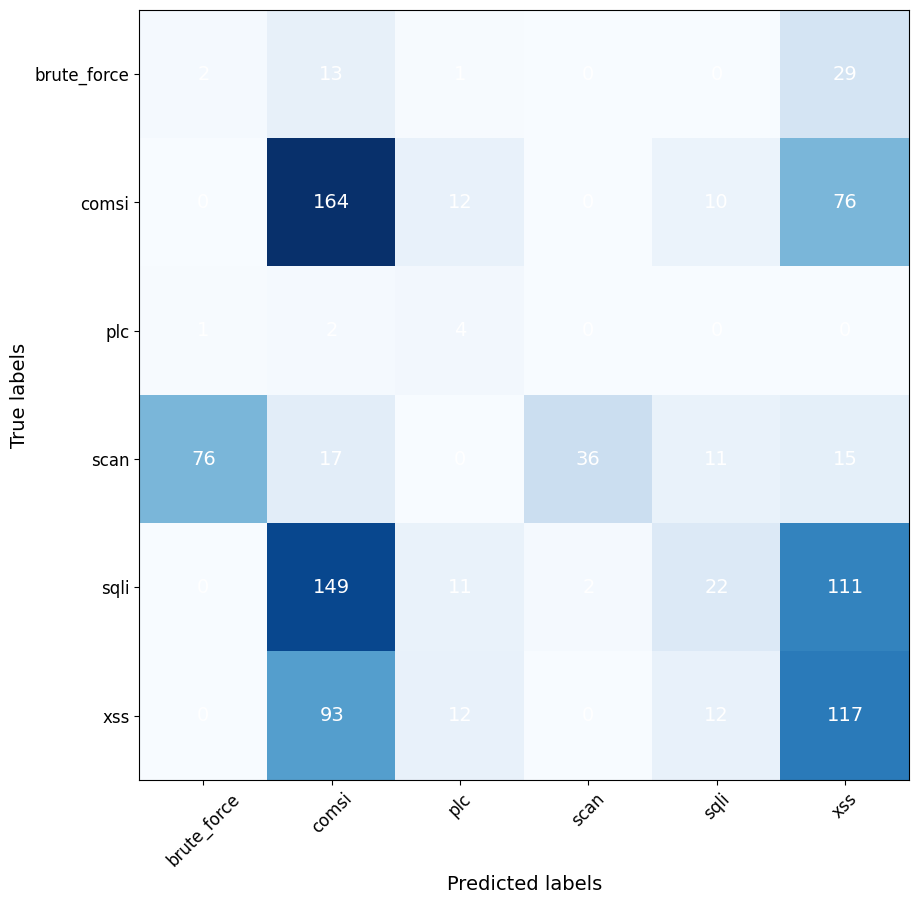

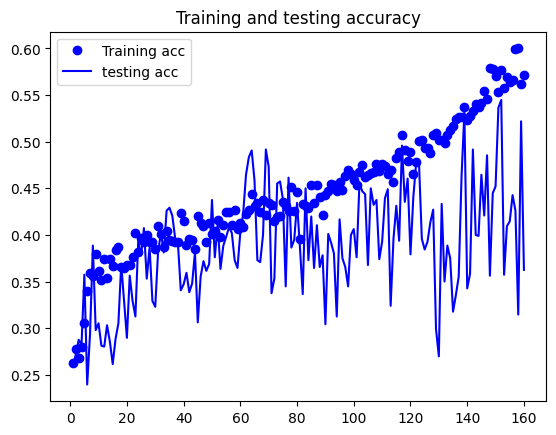

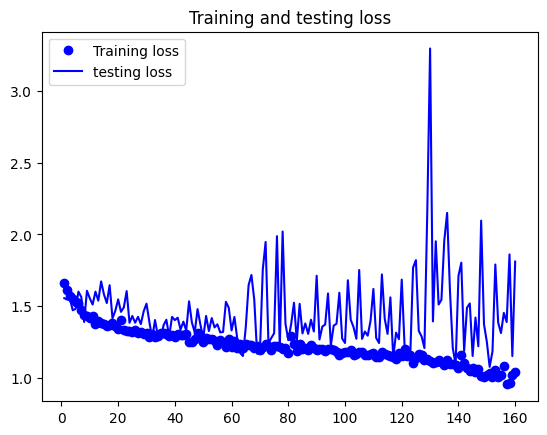

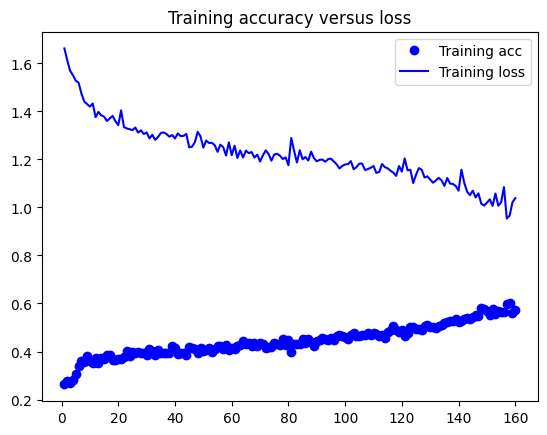

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Get the true labels and predicted labels on the validation set
Y_val = []
Y_pred = []
for i in range(len(test_dataset)):
    x_val, y_val = test_dataset[i]
    Y_val.extend(np.argmax(y_val, axis=1))
    Y_pred.extend(np.argmax(model.predict(x_val), axis=1))

# Generate a classification report and confusion matrix
print('Classification Report')
print(classification_report(Y_val, Y_pred))
print('Confusion Matrix')
cm = confusion_matrix(Y_val, Y_pred)
print(cm)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cm, cmap='Blues')
ax.grid(False)
ax.set_xlabel('Predicted labels', fontsize=14, color='black')
ax.set_ylabel('True labels', fontsize=14, color='black')
ax.set_xticks(range(len(test_dataset.class_indices)))
ax.set_xticklabels(test_dataset.class_indices.keys(), fontsize=12, rotation=45)
ax.set_yticks(range(len(test_dataset.class_indices)))
ax.set_yticklabels(test_dataset.class_indices.keys(), fontsize=12)
for i in range(len(test_dataset.class_indices)):
    for j in range(len(test_dataset.class_indices)):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white', fontsize=14)
plt.show()

# Plot the accuracy and loss curves for training and validation sets

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='testing acc')
plt.title('Training and testing accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='testing loss')
plt.title('Training and testing loss')
plt.legend()
plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training accuracy versus loss')
plt.legend()
plt.show()